### Exploring Anonamoly Detection ML

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime

In [2]:
# Load Data:
df = pd.read_csv("../data/data_stream.csv")

# Feature Generation:
df['start_time'] = pd.to_datetime( df['usage_datetime_start_eastern_time'])
df["month_of_year"] = df["start_time"].dt.month
df["day_of_week"] = df["start_time"].dt.day_of_week
df["hour_of_day"] = df["start_time"].dt.hour
df["time"] = df["start_time"].dt.time
df["date"] = df["start_time"].dt.date
df["year"] = df["start_time"].dt.year
df["minute"] = df["start_time"].dt.minute

#### Full time-series
Reviewing all data we can see that there are some drifts based on seasonality and different years.  Additionally clear there is a data gap near end of 2023.

<Axes: xlabel='start_time'>

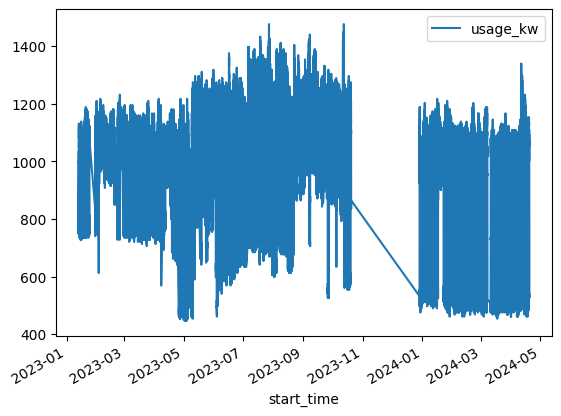

In [3]:
df.plot('start_time', 'usage_kw')

#### Most recent month
There is generally consistent usage trends day to day though some variation within trend.

<Axes: xlabel='start_time'>

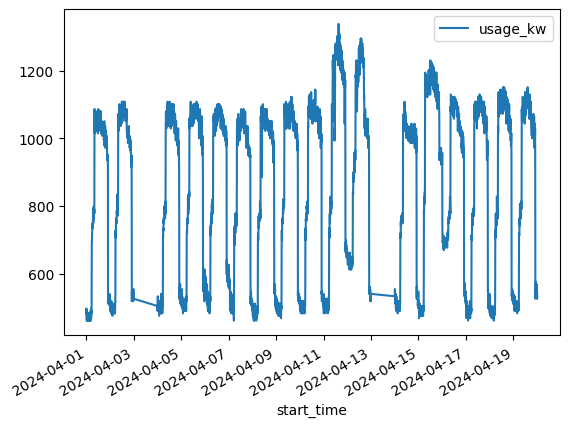

In [9]:
df[ df['start_time'] > '2024-04-01'].plot('start_time', 'usage_kw')

#### Day view
Clear breaks within a day (not necessarily at hour breaks)

<Axes: xlabel='start_time'>

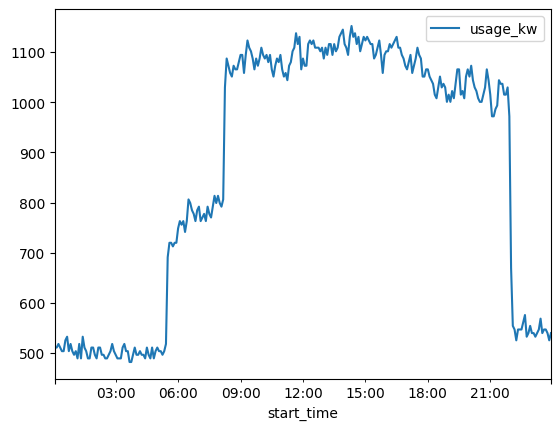

In [4]:
df[ df['start_time'] > '2024-04-19'].plot('start_time', 'usage_kw')

#### Comparison of Days of Week
Different usage trends for M, T, W, H, F, Sa, Su

In [29]:
import plotly.express as px
week_df = df[ 
    # (df.start_time >= "2024-04-06") & (df.start_time < "2024-04-13") 
    (df.day_of_week == 1) & (df.start_time >= "2024-03-01" )
]
fig = px.scatter(week_df, x="time", y="usage_kw",facet_row="date", height=600)
fig.show()

#### Build model based on past X days

In [6]:
window_days = 60
curr_date = datetime.datetime(2024, 4, 19)
window_date_start = curr_date - datetime.timedelta( days=30*3 )

window_df = df [
    (df.start_time >= window_date_start ) & (df.start_time <= curr_date )
]

print (f"Number of data points in window {window_date_start} to {curr_date}: {len(window_df)}")

Number of data points in window 2024-01-20 00:00:00 to 2024-04-19 00:00:00: 23554


In [100]:

dw_mnt_hr_df = window_df [ 
    (window_df.day_of_week == 1) &
    (window_df.minute == 10) &
    (window_df.hour_of_day == 8) 
]

fig = px.scatter(dw_mnt_hr_df, x="date", y="usage_kw")
fig.show()

In [93]:
dw_mnt_hr_df

,usage_datetime_start_eastern_time,usage_datetime_end_eastern_time,usage_kw,start_time,month_of_year,day_of_week,hour_of_day,time,date,year,minute,preds
66809,2024-01-23 08:10:00,2024-01-23 08:15:00,1029.6,2024-01-23 08:10:00,1,1,8,08:10:00,2024-01-23,2024,10,-1
68825,2024-01-30 08:10:00,2024-01-30 08:15:00,799.2,2024-01-30 08:10:00,1,1,8,08:10:00,2024-01-30,2024,10,1
70835,2024-02-06 08:10:00,2024-02-06 08:15:00,813.6,2024-02-06 08:10:00,2,1,8,08:10:00,2024-02-06,2024,10,1
72851,2024-02-13 08:10:00,2024-02-13 08:15:00,741.6,2024-02-13 08:10:00,2,1,8,08:10:00,2024-02-13,2024,10,-1
74864,2024-02-20 08:10:00,2024-02-20 08:15:00,849.6,2024-02-20 08:10:00,2,1,8,08:10:00,2024-02-20,2024,10,-1
76880,2024-02-27 08:10:00,2024-02-27 08:15:00,792.0,2024-02-27 08:10:00,2,1,8,08:10:00,2024-02-27,2024,10,1
78896,2024-03-05 08:10:00,2024-03-05 08:15:00,799.2,2024-03-05 08:10:00,3,1,8,08:10:00,2024-03-05,2024,10,1
80048,2024-03-12 08:10:00,2024-03-12 08:15:00,792.0,2024-03-12 08:10:00,3,1,8,08:10:00,2024-03-12,2024,10,1
81774,2024-03-19 08:10:00,2024-03-19 08:15:00,828.0,2024-03-19 08:10:00,3,1,8,08:10:00,2024-03-19,2024,10,1
83502,2024-03-26 08:10:00,2024-03-26 08:15:00,813.6,2024-03-26 08:10:00,3,1,8,08:10:00,2024-03-26,2024,10,1


In [101]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination="auto", random_state=42)

In [102]:
iso_forest.fit( dw_mnt_hr_df[['usage_kw']] )

IsolationForest(random_state=42)

In [104]:
dw_mnt_hr_df['preds'] = iso_forest.predict( dw_mnt_hr_df[['usage_kw']]  )

/tmp/ipykernel_238116/638125002.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
dw_mnt_hr_df

,usage_datetime_start_eastern_time,usage_datetime_end_eastern_time,usage_kw,start_time,month_of_year,day_of_week,hour_of_day,time,date,year,minute,preds
66809,2024-01-23 08:10:00,2024-01-23 08:15:00,1029.6,2024-01-23 08:10:00,1,1,8,08:10:00,2024-01-23,2024,10,-1
68825,2024-01-30 08:10:00,2024-01-30 08:15:00,799.2,2024-01-30 08:10:00,1,1,8,08:10:00,2024-01-30,2024,10,1
70835,2024-02-06 08:10:00,2024-02-06 08:15:00,813.6,2024-02-06 08:10:00,2,1,8,08:10:00,2024-02-06,2024,10,1
72851,2024-02-13 08:10:00,2024-02-13 08:15:00,741.6,2024-02-13 08:10:00,2,1,8,08:10:00,2024-02-13,2024,10,-1
74864,2024-02-20 08:10:00,2024-02-20 08:15:00,849.6,2024-02-20 08:10:00,2,1,8,08:10:00,2024-02-20,2024,10,-1
76880,2024-02-27 08:10:00,2024-02-27 08:15:00,792.0,2024-02-27 08:10:00,2,1,8,08:10:00,2024-02-27,2024,10,1
78896,2024-03-05 08:10:00,2024-03-05 08:15:00,799.2,2024-03-05 08:10:00,3,1,8,08:10:00,2024-03-05,2024,10,1
80048,2024-03-12 08:10:00,2024-03-12 08:15:00,792.0,2024-03-12 08:10:00,3,1,8,08:10:00,2024-03-12,2024,10,1
81774,2024-03-19 08:10:00,2024-03-19 08:15:00,828.0,2024-03-19 08:10:00,3,1,8,08:10:00,2024-03-19,2024,10,1
83502,2024-03-26 08:10:00,2024-03-26 08:15:00,813.6,2024-03-26 08:10:00,3,1,8,08:10:00,2024-03-26,2024,10,1


In [106]:

fig = px.scatter(dw_mnt_hr_df, x="date", y="usage_kw", color="preds")
fig.show()

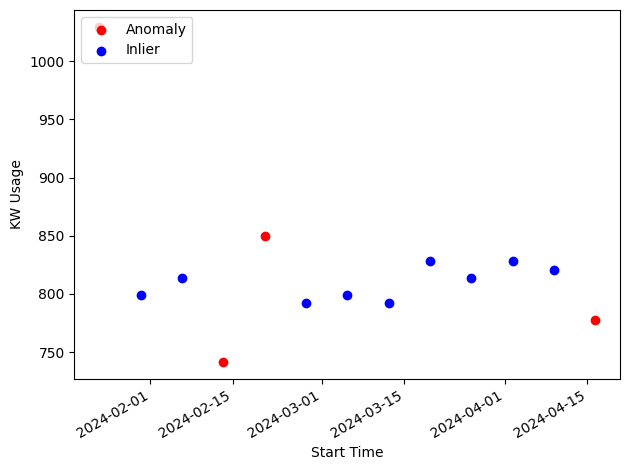

In [91]:
fig, ax = plt.subplots()

df_preds = dw_mnt_hr_df

anomaly_df = df_preds[ df_preds['preds'] == -1 ]
inlier_df = df_preds[ df_preds['preds'] == 1 ]

ax.scatter(anomaly_df.start_time, anomaly_df.usage_kw, color='red', label='Anomaly')
ax.scatter(inlier_df.start_time, inlier_df.usage_kw, color='blue', label='Inlier')
#ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Start Time')
ax.set_ylabel('KW Usage')
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

## Seasonal Decomposition

<Axes: xlabel='start_time'>

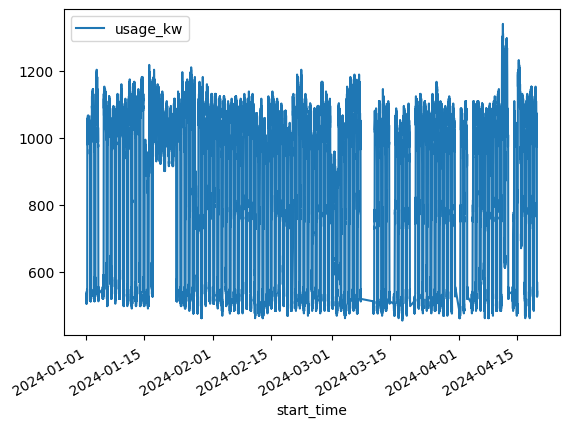

In [8]:
from statsmodels.tsa.seasonal import STL
df_ts = df [["start_time", "usage_kw"]]
df_ts = df_ts[
    df_ts["start_time"] >= "2024-01-01"
]

df_ts = df_ts.set_index("start_time")
df_ts.plot()


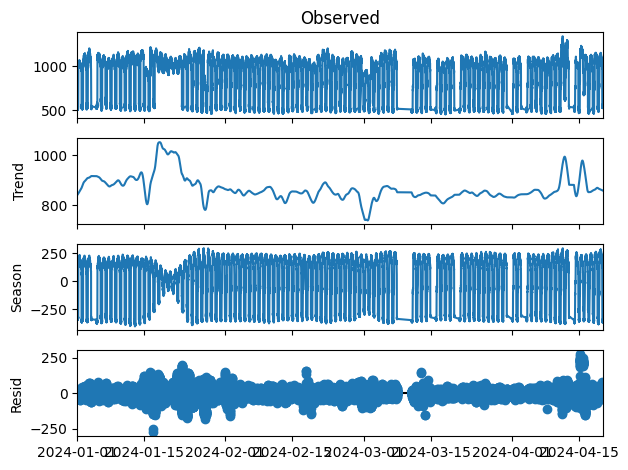

In [10]:
res = STL(df_ts, period=24*12).fit()
res.plot()
plt.show()